# Import Libraries and Data

In [44]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump, load
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import VotingClassifier

%run -i 'functions/model_eval.py'

In [2]:
modeling_df = pd.read_csv('/Users/will4856/Downloads/modeling_df.csv', index_col='Unnamed: 0')
modeling_df.head()

,Title,year,production_budget,domestic_gross,worldwide_gross,profit,ROI,script,Metascore,imdbRating,...,Metascore_scaled,imdbRating_scaled,success_metric,cleaned_scripts,success_failure,word_cloud_scripts,word_count,WPM,unique_word_count,total_vocab_diversity
0,Pirates of the Caribbean: On Stranger Tides,2011,379000000,241063875,1045663875,666663875,1.76,Sub.Re-Edit.by. :: npdv.indoheroes[at]gmail.co...,45.0,6.6,...,0.408602,0.649351,1.38,sub edit npdv indoheroes gmail com advertise p...,0,"['sub', 'edit', 'npdv', 'indoheroes', 'gmail',...",3992,29.4,1547,0.39
1,Avengers: Age of Ultron,2015,365000000,459005868,1396099202,1031099202,2.82,(DISTANT EXPLOSION) STRUCKER ON PA: Report to ...,66.0,7.3,...,0.634409,0.740260,1.56,distant explosion strucker pa report stations ...,1,"['distant', 'explosion', 'strucker', 'pa', 're...",5690,40.4,1869,0.33
2,Justice League,2017,300000000,229024295,655945209,355945209,1.19,"There he is! Oh, sorry. Superman, Superman, ca...",45.0,6.4,...,0.408602,0.623377,1.34,oh sorry superman superman ask questions podca...,0,"['oh', 'sorry', 'superman', 'superman', 'ask',...",3255,27.1,1350,0.41
3,Spectre,2015,300000000,200074175,879620923,579620923,1.93,"Where are you going? I won't be long. Welcome,...",60.0,6.8,...,0.569892,0.675325,1.45,going long welcome signor soiarra trust pleasa...,1,"['going', 'long', 'welcome', 'signor', 'soiarr...",2937,19.8,1245,0.42
4,Batman v Superman: Dawn of Justice,2016,263000000,330360194,872395091,609395091,2.32,There was a time above. A time before. There w...,44.0,6.5,...,0.397849,0.636364,1.36,time time perfect things diamond absolutes thi...,0,"['time', 'time', 'perfect', 'things', 'diamond...",4451,29.5,1748,0.39


In [3]:
#modeling_df.to_csv('/Users/will4856/Desktop/script_model/modeling_df.csv')

# Data Pre-Processing

In [4]:
modeling_df = modeling_df.loc[modeling_df['cleaned_scripts'].notna()]

In [5]:
modeling_df['cleaned_scripts'] = modeling_df['cleaned_scripts'].map(lambda x: ''.join(x))

In [6]:
modeling_df

,Title,year,production_budget,domestic_gross,worldwide_gross,profit,ROI,script,Metascore,imdbRating,...,Metascore_scaled,imdbRating_scaled,success_metric,cleaned_scripts,success_failure,word_cloud_scripts,word_count,WPM,unique_word_count,total_vocab_diversity
0,Pirates of the Caribbean: On Stranger Tides,2011,379000000,241063875,1045663875,666663875,1.76,Sub.Re-Edit.by. :: npdv.indoheroes[at]gmail.co...,45.0,6.6,...,0.408602,0.649351,1.38,sub edit npdv indoheroes gmail com advertise p...,0,"['sub', 'edit', 'npdv', 'indoheroes', 'gmail',...",3992,29.4,1547,0.39
1,Avengers: Age of Ultron,2015,365000000,459005868,1396099202,1031099202,2.82,(DISTANT EXPLOSION) STRUCKER ON PA: Report to ...,66.0,7.3,...,0.634409,0.740260,1.56,distant explosion strucker pa report stations ...,1,"['distant', 'explosion', 'strucker', 'pa', 're...",5690,40.4,1869,0.33
2,Justice League,2017,300000000,229024295,655945209,355945209,1.19,"There he is! Oh, sorry. Superman, Superman, ca...",45.0,6.4,...,0.408602,0.623377,1.34,oh sorry superman superman ask questions podca...,0,"['oh', 'sorry', 'superman', 'superman', 'ask',...",3255,27.1,1350,0.41
3,Spectre,2015,300000000,200074175,879620923,579620923,1.93,"Where are you going? I won't be long. Welcome,...",60.0,6.8,...,0.569892,0.675325,1.45,going long welcome signor soiarra trust pleasa...,1,"['going', 'long', 'welcome', 'signor', 'soiarr...",2937,19.8,1245,0.42
4,Batman v Superman: Dawn of Justice,2016,263000000,330360194,872395091,609395091,2.32,There was a time above. A time before. There w...,44.0,6.5,...,0.397849,0.636364,1.36,time time perfect things diamond absolutes thi...,0,"['time', 'time', 'perfect', 'things', 'diamond...",4451,29.5,1748,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,Princess Mononoke,2005,20000000,2374107,150345863,130345863,6.52,"[In ancient times, the land, lay covered i...",76.0,8.4,...,0.741935,0.883117,1.80,ancient times land lay covered forests ages lo...,1,"['ancient', 'times', 'land', 'lay', 'covered',...",4583,34.2,1235,0.27
3005,Bad Grandpa,2006,15000000,102003019,160903019,145903019,9.73,"[- Is it going?, - Yes., Okay., Leave a messa...",54.0,6.5,...,0.505376,0.636364,1.39,going yes okay leave message irving zisman fuc...,0,"['going', 'yes', 'okay', 'leave', 'message', '...",5659,61.5,1526,0.27
3006,High School Musical 3,2000,11000000,90559416,274392880,263392880,23.94,"[Let's go!, - I'm open, I'm open., - I don't s...",57.0,4.8,...,0.537634,0.415584,1.07,let go open open see take time run run go go l...,0,"['let', 'go', 'open', 'open', 'see', 'take', '...",5185,46.3,1289,0.25
3007,A Nightmare on Elm Street 5: The Dream Child,2014,6000000,22168359,22168359,16168359,2.69,"[Sixty-eight... sixty-nine..., seventy... seve...",54.0,5.2,...,0.505376,0.467532,1.12,sixty eight sixty nine seventy seventy one com...,0,"['sixty', 'eight', 'sixty', 'nine', 'seventy',...",2095,23.5,828,0.40


## Vectorizing

In [7]:
vectorizer = TfidfVectorizer()

In [8]:
X = modeling_df['cleaned_scripts']
y = modeling_df['success_failure']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33)

In [10]:
X_vect = vectorizer.fit_transform(X)
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Dimensionality Reduction with TruncatedSVD

In [11]:
tsvd = TruncatedSVD()

In [12]:
tsvd.fit(X_vect)
X_train_tsvd = tsvd.transform(X_train_tfidf)
X_test_tsvd = tsvd.transform(X_test_tfidf)

# Classification Modeling

## Empty Data Frame for Model Results

In [13]:
model_results = pd.DataFrame()

## XGBoosted Classifier

In [14]:
xgbc_clf = XGBClassifier()

In [15]:
model_eval(xgbc_clf)

              precision    recall  f1-score   support

           0       0.54      0.61      0.57       466
           1       0.60      0.53      0.56       513

    accuracy                           0.57       979
   macro avg       0.57      0.57      0.57       979
weighted avg       0.57      0.57      0.57       979

[[284 182]
 [242 271]]
Training Accuracy Score ->  66.56596173212488
Test Accuracy Score ->  56.69050051072523


In [16]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']

In [17]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [1, 'Vanilla XGBoost RFC', 67.5,57.8,9.7,62.0,54.0,58.0,57.0, 'Vanilla model very basic, needs tuning']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)
model_results

,model_#,model_type,train_accuracy,test_accuracy,train_test_diff,negative_recall,positive_recall,negative_f_1,positive_f-1,notes
0,1,Vanilla XGBoost RFC,67.5,57.8,9.7,62.0,54.0,58.0,57.0,"Vanilla model very basic, needs tuning"


In [18]:
params_xgboost = {'max_depth': range(2,10,1),
         'n_estimators': range(60,220,40),
         'learning_rate': [0.1, 0.01, 0.05]}
estimator_xgboost = XGBClassifier(
    objective= 'binary:logistic',
    n_jobs=-1,
    seed=42, 
)
grid_search_xgboost = GridSearchCV(
    estimator=estimator_xgboost,
    param_grid=params_xgboost,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True)

In [19]:
grid_search_xgboost.fit(X_train_tsvd, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   34.0s finished


GridSearchCV(cv=10, estimator=XGBClassifier(n_jobs=-1, seed=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='accuracy', verbose=True)

In [20]:
grid_search_xgboost.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 60}

In [21]:
xgbc_clf = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.01, max_depth = 2, n_estimators = 100)

In [22]:
model_eval(xgbc_clf)

              precision    recall  f1-score   support

           0       0.55      0.59      0.57       466
           1       0.60      0.56      0.58       513

    accuracy                           0.58       979
   macro avg       0.58      0.58      0.58       979
weighted avg       0.58      0.58      0.58       979

[[277 189]
 [227 286]]
Training Accuracy Score ->  61.17824773413897
Test Accuracy Score ->  57.507660878447396


In [23]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [2, 'XGBoost GridSearched RFC', 61.1,57.5,3.6,59.0,56.0,57.0,58.0, 'GridSearch performed better, no longer overfitting']
results_dict = dict(zip(column_names,results))
model_results2=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results2)
model_results

,model_#,model_type,train_accuracy,test_accuracy,train_test_diff,negative_recall,positive_recall,negative_f_1,positive_f-1,notes
0,1,Vanilla XGBoost RFC,67.5,57.8,9.7,62.0,54.0,58.0,57.0,"Vanilla model very basic, needs tuning"
0,2,XGBoost GridSearched RFC,61.1,57.5,3.6,59.0,56.0,57.0,58.0,"GridSearch performed better, no longer overfit..."


## Support Vector Machine Classifier

In [24]:
svc_clf = SVC()

In [25]:
model_eval(svc_clf)

              precision    recall  f1-score   support

           0       0.56      0.62      0.59       466
           1       0.61      0.55      0.58       513

    accuracy                           0.58       979
   macro avg       0.59      0.58      0.58       979
weighted avg       0.59      0.58      0.58       979

[[289 177]
 [231 282]]
Training Accuracy Score ->  60.87613293051359
Test Accuracy Score ->  58.324821246169556


In [26]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [3, 'Vanilla SVC', 60.8,58.3,2.5,62.0,55.0,59.0,58.0, 'Fit better than RFC, continue with GridSearch']
results_dict = dict(zip(column_names,results))
model_results3=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results3)
model_results

,model_#,model_type,train_accuracy,test_accuracy,train_test_diff,negative_recall,positive_recall,negative_f_1,positive_f-1,notes
0,1,Vanilla XGBoost RFC,67.5,57.8,9.7,62.0,54.0,58.0,57.0,"Vanilla model very basic, needs tuning"
0,2,XGBoost GridSearched RFC,61.1,57.5,3.6,59.0,56.0,57.0,58.0,"GridSearch performed better, no longer overfit..."
0,3,Vanilla SVC,60.8,58.3,2.5,62.0,55.0,59.0,58.0,"Fit better than RFC, continue with GridSearch"


In [27]:
params_svc = {'C': [0.1, 1, 10, 100], 'gamma':[1,0.1,0.01,0.001]}
estimator_svc = SVC(kernel='linear',
                    class_weight='balanced')
grid_search_svc = GridSearchCV(estimator=estimator_svc, 
                              param_grid=params_svc,
                              scoring = 'accuracy',
                              n_jobs = -1,
                              cv = 10,
                              verbose = True)

In [28]:
grid_search_svc.fit(X_train_tsvd, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.5s finished


GridSearchCV(cv=10, estimator=SVC(class_weight='balanced', kernel='linear'),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             scoring='accuracy', verbose=True)

In [29]:
grid_search_svc.best_params_

{'C': 1, 'gamma': 1}

In [30]:
svc_clf = SVC(kernel = 'linear', C = 1, gamma = 1, class_weight='balanced')

In [31]:
model_eval(svc_clf)

              precision    recall  f1-score   support

           0       0.56      0.49      0.52       466
           1       0.58      0.65      0.62       513

    accuracy                           0.58       979
   macro avg       0.57      0.57      0.57       979
weighted avg       0.57      0.58      0.57       979

[[227 239]
 [177 336]]
Training Accuracy Score ->  58.006042296072515
Test Accuracy Score ->  57.507660878447396


In [32]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [4, 'GridSearch SVC', 58.0,57.5,0.5,49.0,65.0,52.0,62.0, 'No longer overfits']
results_dict = dict(zip(column_names,results))
model_results4=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results4)
model_results

,model_#,model_type,train_accuracy,test_accuracy,train_test_diff,negative_recall,positive_recall,negative_f_1,positive_f-1,notes
0,1,Vanilla XGBoost RFC,67.5,57.8,9.7,62.0,54.0,58.0,57.0,"Vanilla model very basic, needs tuning"
0,2,XGBoost GridSearched RFC,61.1,57.5,3.6,59.0,56.0,57.0,58.0,"GridSearch performed better, no longer overfit..."
0,3,Vanilla SVC,60.8,58.3,2.5,62.0,55.0,59.0,58.0,"Fit better than RFC, continue with GridSearch"
0,4,GridSearch SVC,58.0,57.5,0.5,49.0,65.0,52.0,62.0,No longer overfits


## Multinomial Naive Bayes Classifier

In [33]:
nbc = MultinomialNB()

In [34]:
c_vectorizer = CountVectorizer()

In [35]:
Xc_vect = c_vectorizer.fit_transform(X)

In [36]:
X_train_cvect, X_test_cvect, y_train, y_test = train_test_split(Xc_vect, y, test_size = .5)

In [37]:
nbc.fit(X_train_cvect, y_train)

MultinomialNB()

In [38]:
y_test_preds = nbc.predict(X_test_cvect)
y_train_preds = nbc.predict(X_train_cvect)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Training Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)
print("Test Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)

              precision    recall  f1-score   support

           0       0.56      0.85      0.68       751
           1       0.67      0.31      0.43       732

    accuracy                           0.59      1483
   macro avg       0.62      0.58      0.55      1483
weighted avg       0.62      0.59      0.55      1483

[[641 110]
 [504 228]]
Training Accuracy Score ->  85.02024291497976
Test Accuracy Score ->  58.5974376264329


In [39]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [5, 'Multinomial Naive Bayes', 86.3,61.4,22.9,86.0,37.0,69.0,49.0, 'Massive overfitting']
results_dict = dict(zip(column_names,results))
model_results4=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results4)
model_results

,model_#,model_type,train_accuracy,test_accuracy,train_test_diff,negative_recall,positive_recall,negative_f_1,positive_f-1,notes
0,1,Vanilla XGBoost RFC,67.5,57.8,9.7,62.0,54.0,58.0,57.0,"Vanilla model very basic, needs tuning"
0,2,XGBoost GridSearched RFC,61.1,57.5,3.6,59.0,56.0,57.0,58.0,"GridSearch performed better, no longer overfit..."
0,3,Vanilla SVC,60.8,58.3,2.5,62.0,55.0,59.0,58.0,"Fit better than RFC, continue with GridSearch"
0,4,GridSearch SVC,58.0,57.5,0.5,49.0,65.0,52.0,62.0,No longer overfits
0,5,Multinomial Naive Bayes,86.3,61.4,22.9,86.0,37.0,69.0,49.0,Massive overfitting


## Dump Model to PKL File to Deploy

In [40]:
dump(nbc, 'NB_script_model.pkl')

['NB_script_model.pkl']

## Plot Model Results

In [41]:
model_results = model_results.drop(columns = 'train_test_diff')

In [42]:
model_results

,model_#,model_type,train_accuracy,test_accuracy,negative_recall,positive_recall,negative_f_1,positive_f-1,notes
0,1,Vanilla XGBoost RFC,67.5,57.8,62.0,54.0,58.0,57.0,"Vanilla model very basic, needs tuning"
0,2,XGBoost GridSearched RFC,61.1,57.5,59.0,56.0,57.0,58.0,"GridSearch performed better, no longer overfit..."
0,3,Vanilla SVC,60.8,58.3,62.0,55.0,59.0,58.0,"Fit better than RFC, continue with GridSearch"
0,4,GridSearch SVC,58.0,57.5,49.0,65.0,52.0,62.0,No longer overfits
0,5,Multinomial Naive Bayes,86.3,61.4,86.0,37.0,69.0,49.0,Massive overfitting


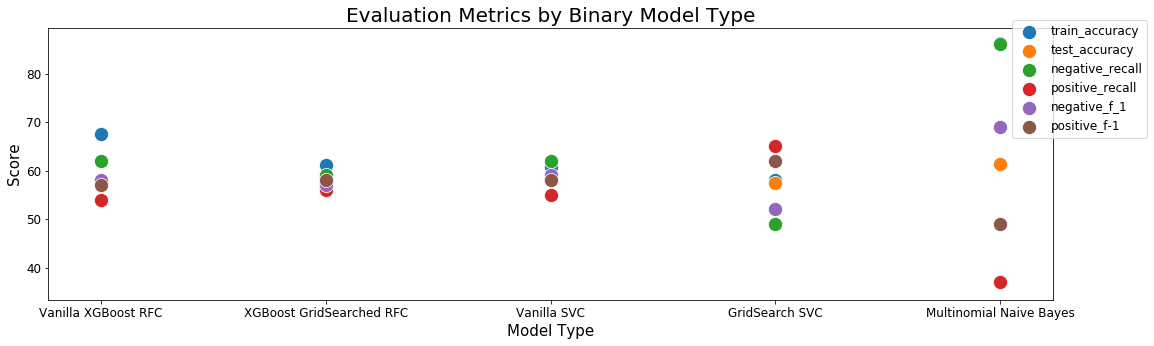

In [43]:
cols_to_plot=model_results.columns[2:8]
plt.figure(figsize=(18,5))
for col in cols_to_plot:
    #used a for loop to plot evaluation metrics data from model_results data frame
    sns.scatterplot(data=model_results, y=col, x='model_type', label = col,s=200)
plt.title('Evaluation Metrics by Binary Model Type',size=20)
plt.xlabel('Model Type',size=15)
plt.ylabel('Score',size = 15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(fontsize='large', bbox_to_anchor=(1.1, 1.05))
plt.show()

# Introduce More Features to Model

## Run Model with Only New Features

### XGBoosted RFC

In [46]:
X = modeling_df[['word_count', 'WPM', 'unique_word_count', 'total_vocab_diversity']]
y = modeling_df['success_failure']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [48]:
xgb_clf = XGBClassifier()

In [49]:
xgb_clf.fit(X_train, y_train)
y_test_preds = xgb_clf.predict(X_test)
y_train_preds = xgb_clf.predict(X_train)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Training Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)
print("Test Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       279
           1       0.68      0.61      0.64       314

    accuracy                           0.64       593
   macro avg       0.64      0.64      0.64       593
weighted avg       0.64      0.64      0.64       593

[[187  92]
 [121 193]]
Training Accuracy Score ->  72.80775716694772
Test Accuracy Score ->  64.08094435075886


In [50]:
params_xgboost = {'max_depth': range(2,10,1),
         'n_estimators': range(60,220,40),
         'learning_rate': [0.1, 0.01, 0.05]}
estimator_xgboost = XGBClassifier(
    objective= 'binary:logistic',
    n_jobs=-1,
    seed=42, 
)
grid_search_xgboost = GridSearchCV(
    estimator=estimator_xgboost,
    param_grid=params_xgboost,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True)

In [51]:
grid_search_xgboost.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   53.2s finished


GridSearchCV(cv=10, estimator=XGBClassifier(n_jobs=-1, seed=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='accuracy', verbose=True)

In [53]:
grid_search_xgboost.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 140}

In [60]:
xgb_clf = XGBClassifier(learning_rate=0.05, max_depth=1, n_estimators=140)

In [61]:
xgb_clf.fit(X_train, y_train)
y_test_preds = xgb_clf.predict(X_test)
y_train_preds = xgb_clf.predict(X_train)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Training Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)
print("Test Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       279
           1       0.69      0.43      0.53       314

    accuracy                           0.60       593
   macro avg       0.62      0.61      0.59       593
weighted avg       0.62      0.60      0.59       593

[[218  61]
 [178 136]]
Training Accuracy Score ->  62.605396290050585
Test Accuracy Score ->  59.696458684654296


# Conclusion

While I was able to successfully run a classifier model with the script dialogue and features that were engineered using the same data, I do not believe that I ultimately had enough data to make reliable predictions on new scripts. This issue arose from a lack of reliable and accurate full scripts available online and from a lack of time that I could spend parsing dialogue transcripts. I do think that given that my best models performed at around 62% accuracy on the test set, which is significantly higher than a coin flip percentage (50%), there is a correlation between the content of the script and it's ultimate success once released.